In [1]:
# 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

# 2. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа.
#    Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.

# 3. Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы. 

# 4 (опция). Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и 
#            построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [290]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [372]:
class KnnClassifier:
    
    def __init__(self,
                 n_neighbors: int=3,
                 dist: str='man',
                 weight: str='none'):
        self.n_neighbors = n_neighbors
        self.dist = 2 if dist == 'man' else 1
        self.weight = weight
        
        
    def get_distance(self, x1: np.array, x2:np.array) -> np.array:
        if len(x2.shape) == 1:
            return np.sum((x1 - x2) ** self.dist, axis=0) ** (1 / self.dist)
        return np.sum((x1 - x2) ** self.dist, axis=1) ** (1 / self.dist)
    
        
    def predict(self,
                X_train: np.array,
                y_train: np.array,
                X_test: np.array) -> np.array:
        
        result = []
        
        for sample in X_test:
            distances = self.get_distance(sample, X_train)
            targets = []
            
            if self.weight == 'ind':
                classes = {_class: 0 for _class in set(y_train)}
                weights = np.array([1 / index for index in range(2, self.n_neighbors + 2)])
                for distance in np.sort(distances)[:self.n_neighbors]:
                    idx = np.where(distances == distance)[0][0]
                    classes[y_train[idx]] += weights[np.where(np.sort(distances)[:self.n_neighbors] == distance)][0] * distance
                result.append(max(classes, key=classes.get))                   
                            
            elif self.weight == 'dist':
                classes = {_class: 0 for _class in set(y_train)}
                weights = np.array([np.mean(distances) / dist for dist in np.sort(distances)[:self.n_neighbors]])

                for distance in np.sort(distances)[:self.n_neighbors]:
                    idx = np.where(distances == distance)[0][0]
                    classes[y_train[idx]] += weights[np.where(np.sort(distances)[:self.n_neighbors] == distance)][0] * distance
                result.append(max(classes, key=classes.get))                   
            
            else:
                for distance in np.sort(distances)[:self.n_neighbors]:
                    index = np.where(distances == distance)[0][0]
                    targets.append(y_train[index])
                result.append(max(targets, key=targets.count))
                
        return np.array(result)

In [373]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [488]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    knn = KnnClassifier(n_neighbors=k, weight='none')
    Z = knn.predict(X_train[:, :2], y_train, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    acc = accuracy(knn.predict(X_train[:, :2], y_train, X_test[:, :2]), y_test)
    axs[0].pcolormesh(xx, yy, Z, cmap=cmap_light)
    axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    axs[0].text(4.5, 4.7, f'n_neighbors: {k}\naccuracy: {acc:.2f}\nweights: NONE', fontsize=14)
    
    knn = KnnClassifier(n_neighbors=k, weight='ind')
    Z = knn.predict(X_train[:, :2], y_train, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    acc = accuracy(knn.predict(X_train[:, :2], y_train, X_test[:, :2]), y_test)
    axs[1].pcolormesh(xx, yy, Z, cmap=cmap_light)
    axs[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    axs[1].text(4.5, 4.7, f'n_neighbors: {k}\naccuracy: {acc:.2f}\nweights: INDEX', fontsize=14)
    
    knn = KnnClassifier(n_neighbors=k, weight='dist')
    Z = knn.predict(X_train[:, :2], y_train, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    acc = accuracy(knn.predict(X_train[:, :2], y_train, X_test[:, :2]), y_test)
    axs[2].pcolormesh(xx, yy, Z, cmap=cmap_light)
    axs[2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)

    axs[2].text(4.5, 4.7, f'n_neighbors: {k}\naccuracy: {acc:.2f}\nweights: DISTANCE', fontsize=14)

    fig.show()

<ipython-input-488-673e1feb4075>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(xx, yy, Z, cmap=cmap_light)
<ipython-input-488-673e1feb4075>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(xx, yy, Z, cmap=cmap_light)
<ipython-input-372-2801fd113f02>:39: RuntimeWarning: divide by zero encountered in double_scalars
  weights = np.array([np.mean(distances) / dist for dist in np.sort(distances)[:self.n_neighbors]])
<ipyth

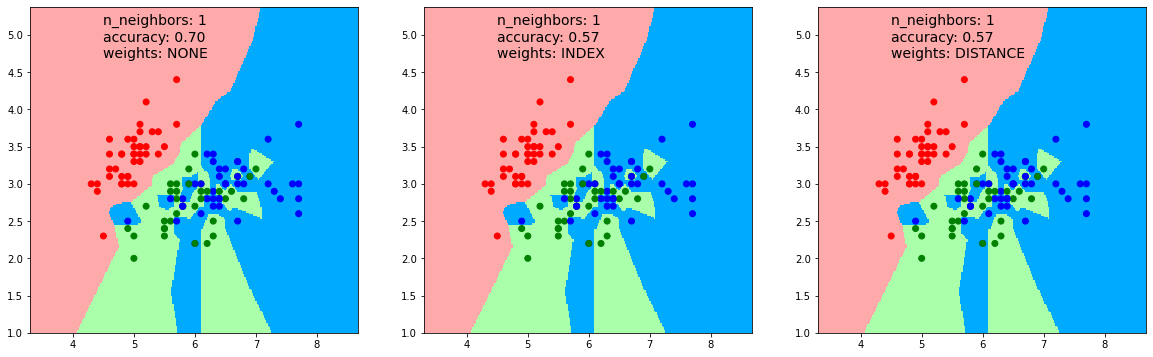

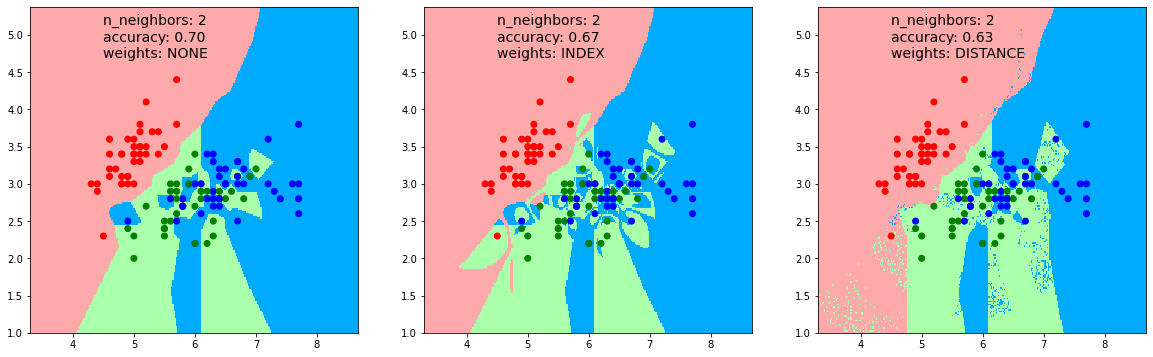

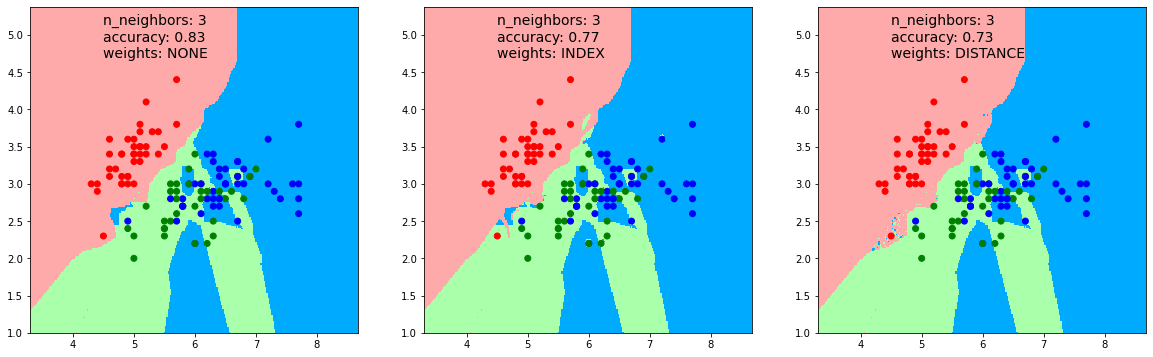

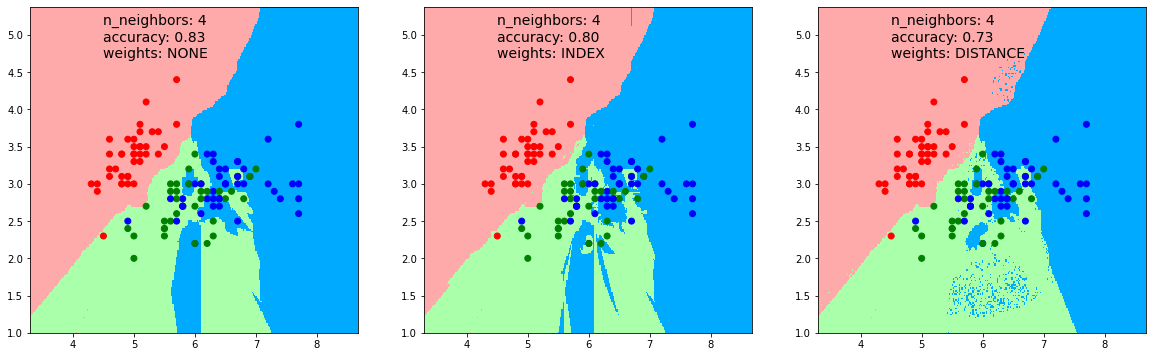

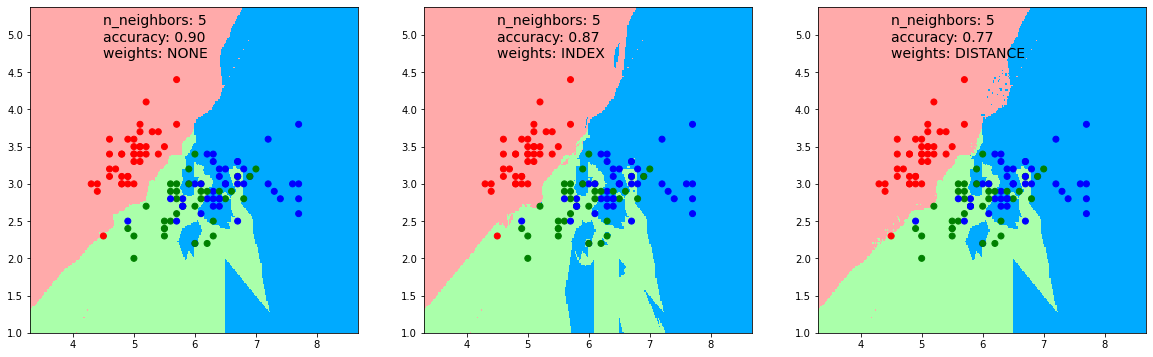

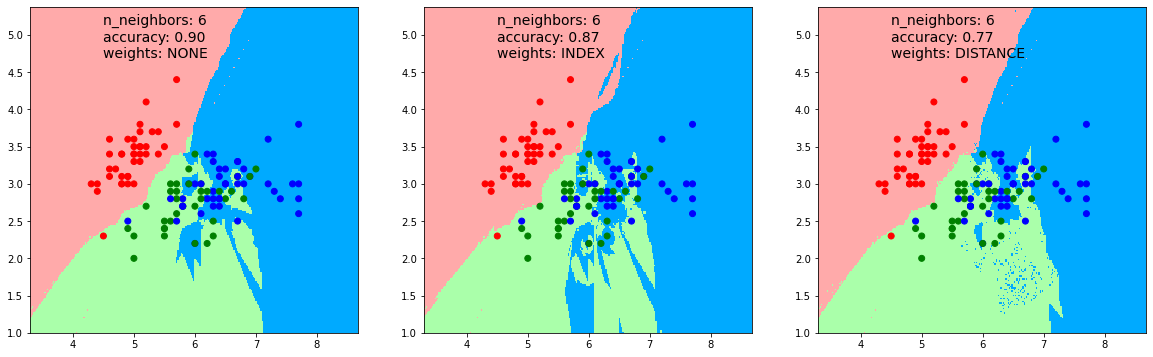

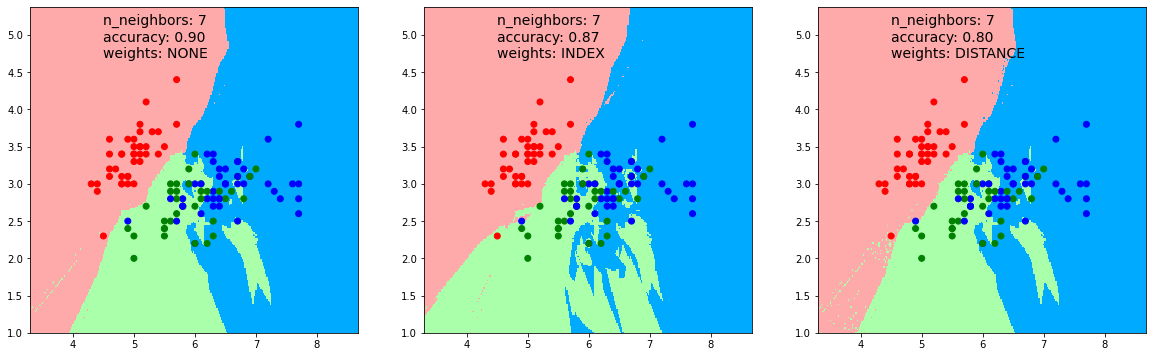

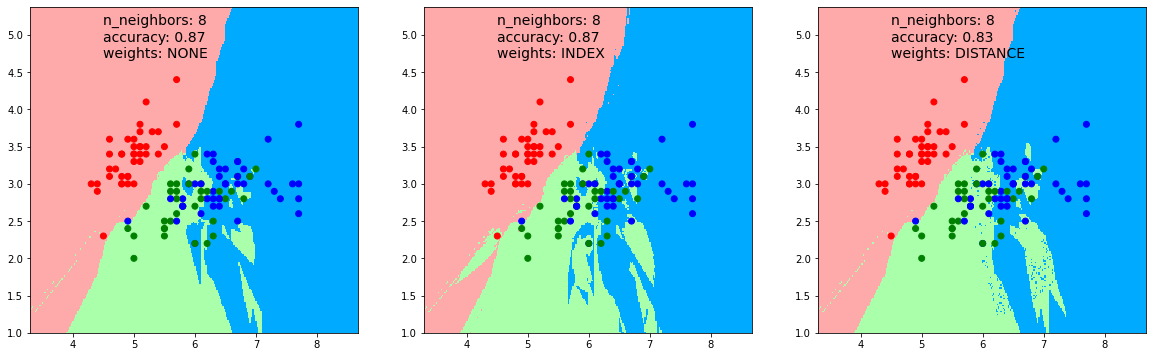

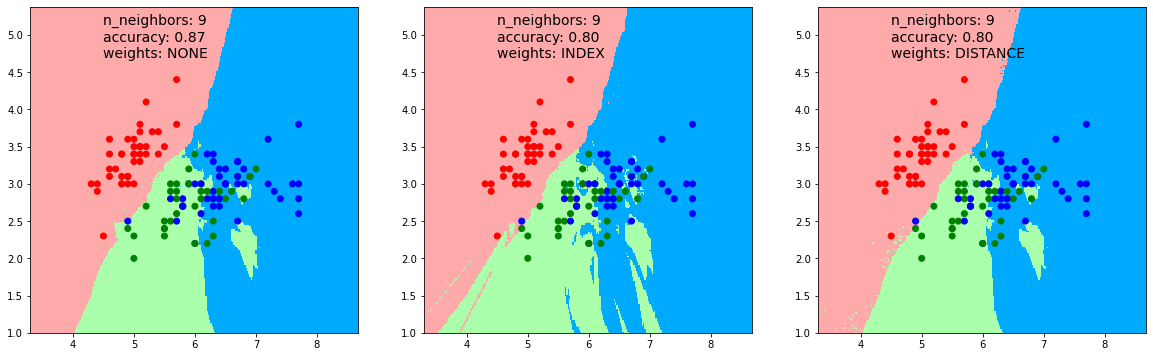

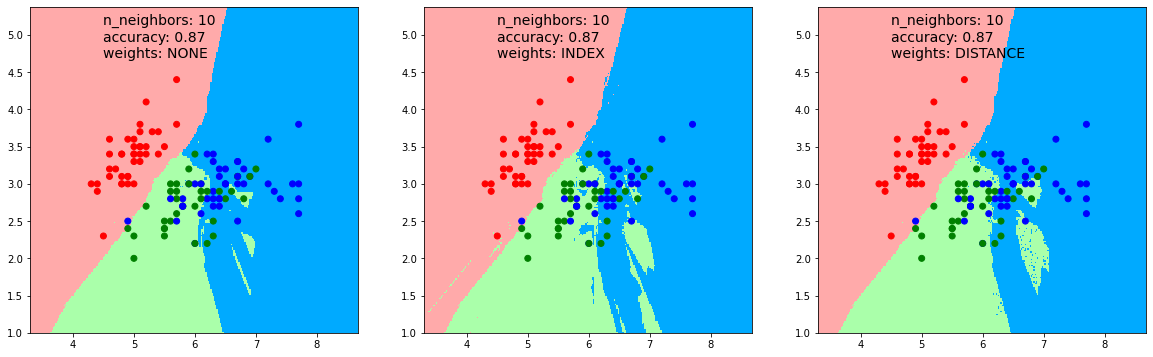

In [489]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
neighbors_list = [i for i in range(1, 11)]
for neighbor in neighbors_list:
    get_graph(X_train, y_train, neighbor)

Как видно из графиков, лучшие результаты показали модели с 7 соседями. Мне показалось, что добавление весов не очень способствует улучшению классификации на данном датасете. Или я что-то неправильно сделал.